# Transformer Based Classification

In [2]:
# We had the dataset on drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Should be run every time on colab
!pip install qalsadi
!pip install datasets
!pip install camel_tools
!pip install tashaphyne
!pip install hazm
!pip install -r drive/MyDrive/quran_mir/requirements.txt
%cd drive/MyDrive/quran_mir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 372 kB/s 
     |████████████████████████████████| 138 kB 49.0 MB/s 
     |████████████████████████████████| 9.2 MB 47.3 MB/s 
     |████████████████████████████████| 353 kB 51.2 MB/s 
     |████████████████████████████████| 332 kB 51.5 MB/s 
     |████████████████████████████████| 251 kB 43.1 MB/s 
     |████████████████████████████████| 126 kB 48.4 MB/s 
  Created wheel for pickledb: filename=pickleDB-0.9.2-py3-none-any.whl size=4271 sha256=36f18c7a12ffed807bd4a1d60510c04a28f97f81ea55321c2c8eecf16b667633
  Stored in directory: /root/.cache/pip/wheels/08/34/42/9a7f94099208ce3d32638d98586a5a50f821db2fc75a3bdaae
Successfully built pickledb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.2 MB

In [36]:
# Basic imports
from preprocess_quran_text import merged_quran_vec_df_nrmlz
import pandas as pd
import numpy as np
import pandas as pd
import qalsadi.lemmatizer
from nltk.stem.isri import ISRIStemmer
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score, 
    precision_score, 
    recall_score, 
    classification_report, 
    confusion_matrix
)
import seaborn as sns
from datasets import Dataset, DatasetDict, load_metric

from transformers.optimization import Adafactor, AdafactorSchedule
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline, \
    AutoModelForSequenceClassification, TrainingArguments, Trainer

import pandas as pd
import torch
import os


stemmer = ISRIStemmer()
lemmer = qalsadi.lemmatizer.Lemmatizer()  # This is a weak Lemmatizer.

## Create Dataset

Since we dont have enough data for a finetuning, we increase our data by 
copying it additionally in different formats (original, lemmatized, rooted).
first we concat the whole dataset in each format and then we randomly lemmatize or rootify (if its a word) tokens in the dataset and repeat the whole dataset 5 more times.


In [35]:
X = merged_quran_vec_df_nrmlz[['original_normalized', 'lemma_normalized', 'root_normalized']].copy()
X['شماره سوره'] = X.index.to_series().str.split('##').apply(lambda x: int(x[0]))
X['شماره آیه'] = X.index.to_series().str.split('##').apply(lambda x: int(x[1]))

top_sures = X.groupby('شماره سوره').count().sort_values(by='شماره آیه', ascending=False).reset_index()['شماره سوره'][:30]
top_x = X[X['شماره سوره'].isin(top_sures)]
top_x

id2label = {}
label2id = {}
for i, l in enumerate(set(top_x['شماره سوره'].tolist())):
    id2label[i] = l
    label2id[l] = i

def create_data_set(out_dir: str, merged_df: pd.DataFrame, lemma_rate=0, root_rate=0, expansion_count=0):
    with open(out_dir, 'w') as fp:
        fp.write('text,aye_no,sure_no,labels\n')
        for col in tqdm.tqdm(['original_normalized', 'lemma_normalized', 'root_normalized']):
            for i, r in merged_df.iterrows():
              fp.write(r[col]+','+str(r['شماره آیه'])+','+str(r['شماره سوره'])+','+str(label2id[r['شماره سوره']]))
              fp.write('\n')
        probabilities = [1 - lemma_rate - root_rate, lemma_rate, root_rate]
        functions = [lambda x: x, lemmer.lemmatize, stemmer.stem]
        for _ in range(expansion_count):  # can be enhanced
            for i, r in tqdm.tqdm(merged_df.iterrows()):
                fp.write(
                    ' '.join([np.random.choice(a=functions, p=probabilities)(token)
                                        for token in r['original_normalized'].split()])
                )
                fp.write(','+str(r['شماره آیه'])+','+str(r['شماره سوره'])+','+str(label2id[r['شماره سوره']]))
                fp.write('\n')




In [ ]:
# Takes a while
create_data_set(out_dir='transformer_classification_dataset.csv', merged_df=top_x,
                                                                lemma_rate=0.2,
                                                                root_rate=0.2,
                                                                expansion_count=5)

100%|██████████| 3/3 [00:00<00:00,  4.75it/s]
3800it [00:35, 106.62it/s]
3800it [00:36, 103.77it/s]
3800it [00:35, 106.88it/s]
3800it [00:34, 110.75it/s]
3800it [00:35, 108.35it/s]


## Model
We use arabert for this purpose and fine-tune it in order to use it for our 
classification task.
In our experience only 5 iterations is enough. we save the model after each iteration.

In [38]:
class ClassificationModel:

    def __init__(self, model_name, num_labels):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                        num_labels=num_labels).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.classifier = pipeline(
            "sentiment-analysis", model=self.model, tokenizer=self.tokenizer)

    @staticmethod
    def training_args_builder(output_dir="./models/", learning_rate=2e-3, train_batch_size=32,
                              eval_batch_size=32, num_train_epochs=30, weight_decay=0.01):
        return TrainingArguments(
            output_dir=output_dir,
            per_device_train_batch_size=train_batch_size,
            per_device_eval_batch_size=eval_batch_size,
            weight_decay=weight_decay,
            learning_rate=learning_rate,
            num_train_epochs=num_train_epochs,
        )

    def get_train_valid_test(self, dataset, valid_ratio=0.1, test_ratio=0.1):
        train_dataset, test_valid_dataset = train_test_split(
            dataset, test_size=(valid_ratio + test_ratio), random_state=42, shuffle=True
        )
        valid_dataset, test_dataset = train_test_split(
            test_valid_dataset, test_size=((test_ratio)/(valid_ratio + test_ratio)),
            random_state=42, shuffle=True
        )

        return (
            Dataset.from_dict(train_dataset),
            Dataset.from_dict(valid_dataset),
            Dataset.from_dict(test_dataset)
        )

    def train(self, train_dataset, valid_dataset, training_args=None):
        training_args = training_args or self.training_args_builder()

        dataset = DatasetDict({"train": train_dataset, "valid": valid_dataset})

        def preprocess_function(data):
            return self.tokenizer(data["text"], truncation=True, padding=True)

        tokenized_data = dataset.map(
            preprocess_function, batched=True, remove_columns=['text'])
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        optimizer = Adafactor(
            self.model.parameters(), scale_parameter=True, 
                                    relative_step=True,
                                    warmup_init=True, lr=None)
        lr_scheduler = AdafactorSchedule(optimizer)

        trainer = Trainer(
            eval_dataset=tokenized_data["valid"],
            train_dataset=tokenized_data["train"],
            model=self.model,
            args=training_args,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            optimizers=(optimizer, lr_scheduler),
        )

        for i in range(5):
          self.classifier.model.to('cpu')
          results = self.predict(valid_dataset['text'])
          f1_micro, f1_macro, f1_weighted, accuracy = self.get_metrics(results, valid_dataset)
          print('scores: f1 =', f1_weighted, 'accuracy =', accuracy)
          self.classifier.model.save_pretrained(f'./models/model_acc_{round(accuracy["accuracy"], 2)}')
          self.classifier.model.to(self.device)
          trainer.train()
          
          
    def get_metrics(self, predictions, test_data):
      f1_micro = f1_score(test_data['labels'], predictions, average='micro')
      f1_macro = f1_score(test_data['labels'], predictions, average='macro')
      f1_weighted = f1_score(test_data['labels'], predictions, average='weighted')

      accuracy = accuracy_score(test_data['labels'], predictions)

      return f1_micro, f1_macro, f1_weighted, accuracy

    def predict(self, test_data):
        inner_labels = self.classifier(test_data)
        return list(map(lambda lab: int(lab['label'].split('_')[1]), inner_labels))




In [39]:
# load the save dataset
df = pd.read_csv('./transformer_classification_dataset.csv', 
                 converters={
                     'aye_no':int,
                     'sure_no':int,
                     'labels':int
                 })
df.head()

,text,aye_no,sure_no,labels
0,الم,1,2,0
1,ذلك الكتاب لا ريب فيه هدي للمتقين,2,2,0
2,الذين يومنون بالغيب و يقيمون الصلاه و مما رزقن...,3,2,0
3,و الذين يومنون بما انزل اليك و ما انزل من قبلك...,4,2,0
4,اولئك علي هدي من ربهم و اولئك هم المفلحون,5,2,0


In [ ]:
# TRAINING LOOP. DONT RUN.

model = ClassificationModel(model_name='aubmindlab/bert-base-arabertv2', num_labels=30)
train_data, valid_data, test_data = model.get_train_valid_test(df, valid_ratio=0.01, test_ratio=0.01)

training_args = model.training_args_builder(
    learning_rate=1e-2,
    num_train_epochs=1,
)


model.train(train_data, valid_data, training_args)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Configuration saved in ./models/model_acc_0.04/config.json


scores: f1 = {'f1': 0.039473684210526314} accuracy = {'accuracy': 0.039473684210526314}


Model weights saved in ./models/model_acc_0.04/pytorch_model.bin
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sure_no, aye_no. If sure_no, aye_no are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 29792
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 931


Step,Training Loss
500,3.110000


Trainer is attempting to log a value of "3.491582901915535e-05" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./models/model_acc_0.38/config.json


scores: f1 = {'f1': 0.375} accuracy = {'accuracy': 0.375}


Model weights saved in ./models/model_acc_0.38/pytorch_model.bin
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sure_no, aye_no. If sure_no, aye_no are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 29792
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 931


Step,Training Loss
500,1.796600


Trainer is attempting to log a value of "9.993302955990657e-05" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./models/model_acc_0.72/config.json


scores: f1 = {'f1': 0.7171052631578947} accuracy = {'accuracy': 0.7171052631578947}


Model weights saved in ./models/model_acc_0.72/pytorch_model.bin
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sure_no, aye_no. If sure_no, aye_no are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 29792
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 931


Step,Training Loss


Step,Training Loss
500,0.850200


Trainer is attempting to log a value of "0.00016497212345711887" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./models/model_acc_0.75/config.json


scores: f1 = {'f1': 0.75} accuracy = {'accuracy': 0.75}


Model weights saved in ./models/model_acc_0.75/pytorch_model.bin
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sure_no, aye_no. If sure_no, aye_no are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 29792
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 931


Step,Training Loss
500,0.580000


Trainer is attempting to log a value of "0.0002300637133885175" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


## Evaluation and Reports

In [52]:
# load saved model
model = ClassificationModel(model_name='aubmindlab/bert-base-arabertv2', num_labels=30)
train_data, valid_data, test_data = model.get_train_valid_test(df, valid_ratio=0.01, test_ratio=0.01)
model_core = AutoModelForSequenceClassification.from_pretrained('./models/model_acc_0.75')
model.model = model_core
model.classifier.model = model_core

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

### Evaluation

In [53]:
pred = model.predict(test_data['text'])
f1_micro, f1_macro, f1_weighted, accuracy = model.get_metrics(pred, test_data)
print(
    f'''
    f1 micro: {f1_micro}
    f1 macro: {f1_macro}
    f1 weighted avg: {f1_weighted}
    accuracy: {accuracy}
    '''
)


    f1 micro: 0.8223684210526315
    f1 macro: 0.8086013826753481
    f1 weighted avg: 0.8179553454101657
    accuracy: 0.8223684210526315
    


### Confusion Matrix Heatmap

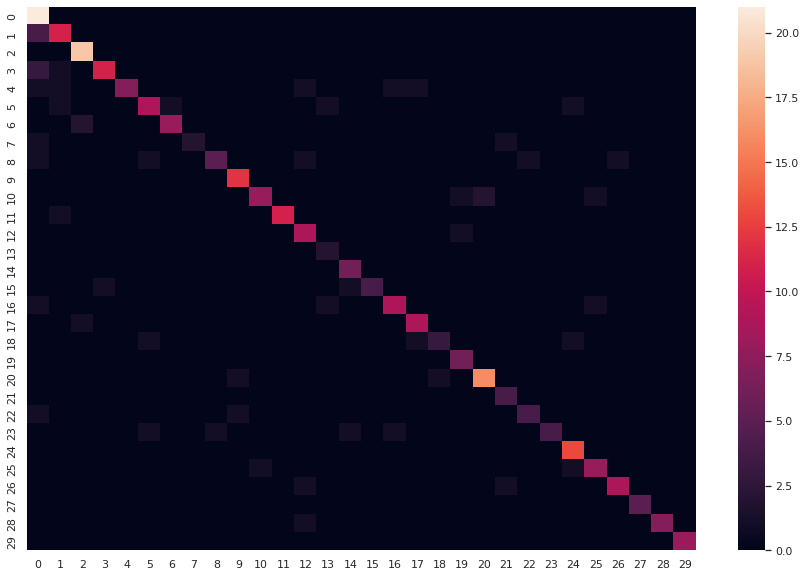

In [58]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(confusion_matrix(test_data['labels'], pred))

## Save Model's Prediction Results

In [63]:
all_pred = model.predict(top_x['original_normalized'].tolist())
all_pred[:5]

[0, 0, 0, 0, 0]

In [66]:
top_x['predicted_sure'] = [id2label[x] for x in all_pred]
top_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,original_normalized,lemma_normalized,root_normalized,شماره سوره,شماره آیه,predicted_sure
index,,,,,,
2##1,الم,الٓمٓ,الٓمٓ,2,1,2
2##2,ذلك الكتاب لا ريب فيه هدي للمتقين,ذلك كتب لا ريب في هدي متقين,كتب ريب هدي وقي,2,2,2
2##3,الذين يومنون بالغيب و يقيمون الصلاه و مما رزقن...,الذي امن غيب اقام صلوه من ما رزق انفق,امن غيب قوم صلو رزق نفق,2,3,2
2##4,و الذين يومنون بما انزل اليك و ما انزل من قبلك...,الذي امن ما انزل الي ما انزل من قبل آخر يوقن,امن نزل نزل قبل اخر يقن,2,4,2
2##5,اولئك علي هدي من ربهم و اولئك هم المفلحون,اولٓئك علي هدي من رب اولٓئك مفلحون,هدي ربب فلح,2,5,2
...,...,...,...,...,...,...
56##92,و اما ان كان من المكذبين الضالين,اما ان كان من مكذبين ضآل,كون كذب ضلل,56,92,56
56##93,فنزل من حميم,نزل من حميم,نزل حمم,56,93,56
56##94,و تصليه جحيم,تصليه جحيم,صلي جحم,56,94,56


In [68]:
top_x.loc[:, ['original_normalized', 'شماره سوره', 'شماره آیه', 'predicted_sure']].to_csv('./final_report.csv')